In [1]:
import numpy as np
import getdist
from getdist import plots
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy
import random
%matplotlib inline

import getdist.plots as gplot
from getdist import MCSamples
from getdist import loadMCSamples

import tensiometer as ten
from tensiometer import gaussian_tension
from tensiometer import mcmc_tension
from tensiometer import utilities as utils

# GENERAL PLOT OPTIONS
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1.0'
matplotlib.rcParams['axes.labelsize'] = 'medium'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.linewidth'] = '0.0'
matplotlib.rcParams['grid.alpha'] = '0.18'
matplotlib.rcParams['grid.color'] = 'lightgray'
matplotlib.rcParams['legend.labelspacing'] = 0.77
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.format'] = 'pdf'

analysissettings={'smooth_scale_1D':0.25,
                  'smooth_scale_2D':0.25,
                  'ignore_rows': u'0.35',
                  'range_confidence' : u'0.005'}

analysissettings2={'smooth_scale_1D':0.25,
                   'smooth_scale_2D':0.25,
                   'ignore_rows': u'0.0',
                   'range_confidence' : u'0.005'}

chaindir = os.environ['ROOTDIR']+'/projects/example/chains/TM/'

# Definitions:

In [2]:
def get_diff_chain(root_chains, 
                   num_points_thin=50000, 
                   print_param_names_diff=False, 
                   plot=False):
    # -----------------------------------------------------------------------------
    # SAMPLES1 --------------------------------------------------------------------
    # -----------------------------------------------------------------------------
    i=0
    samples1 = loadMCSamples(chaindir + root_chains[i], settings=analysissettings);
    samples1.thin(factor = max(int(np.sum(samples1.weights)/num_points_thin),1))
    p = samples1.getParams();
    samples1.saveAsText(chaindir +  '.tmp1_' + str(i));
    samples1 = loadMCSamples(chaindir +  '.tmp1_' + str(i), settings=analysissettings2);
    # -----------------------------------------------------------------------------
    # SAMPLES2 --------------------------------------------------------------------
    # -----------------------------------------------------------------------------
    i=1
    samples2 = loadMCSamples(chaindir + root_chains[i], settings=analysissettings);
    samples2.thin(factor = max(int(np.sum(samples2.weights)/num_points_thin),1))
    p = samples2.getParams();
    samples2.saveAsText(chaindir +  '.tmp2_' + str(i));
    samples2 = loadMCSamples(chaindir +  '.tmp2_' +  str(i), settings=analysissettings2);
    # -----------------------------------------------------------------------------
    # Diff Chain ------------------------------------------------------------------
    # -----------------------------------------------------------------------------
    diff_chain = mcmc_tension.parameter_diff_chain(samples1, samples2, boost=1)
    if print_param_names_diff == True:
        print(diff_chain.getParamNames())
    # -----------------------------------------------------------------------------
    # TENSION METRIC --------------------------------------------------------------
    # -----------------------------------------------------------------------------
    return (samples1, samples2, diff_chain);

In [3]:
def get_udm_tension(root_chains, 
                    num_points_thin = 50000, 
                    param_names = None, 
                    plot = False, 
                    print_param_names_diff=False):
    (samples1, samples2, diff_chain) = get_diff_chain(root_chains=root_chains, 
                                                      num_points_thin=num_points_thin, 
                                                      plot=plot, 
                                                      print_param_names_diff=print_param_names_diff)
    if plot == True:
        diff_param_names = diff_chain.getParamNames();
        g = plots.get_subplot_plotter()
        g.triangle_plot([diff_chain], params=diff_param_names, filled=True, markers={_p:0 for _p in diff_param_names})    
    # -----------------------------------------------------------------------------
    # Tension Computation ---------------------------------------------------------
    # -----------------------------------------------------------------------------
    Q_UDM, Q_UDM_dofs = gaussian_tension.Q_UDM(samples1, samples2, param_names=param_names)
    Q_UDM_P = scipy.stats.chi2.cdf(Q_UDM, Q_UDM_dofs)
    Q_UDM_nsigma = utils.stats_utilities.from_confidence_to_sigma(Q_UDM_P)
    return Q_UDM_nsigma

In [13]:
def get_ng_tension(root_chains, 
                   num_points_thin=50000, 
                   param_names=None, 
                   plot=False, 
                   feedback=1,
                   print_param_names_diff=False):
    (samples1, samples2, diff_chain) = get_diff_chain(root_chains=root_chains, 
                                                      num_points_thin=num_points_thin, 
                                                      plot=plot, 
                                                      print_param_names_diff=print_param_names_diff)
    if plot:
        param_names2 = diff_chain.getParamNames();
        g = plots.get_subplot_plotter()
        g.triangle_plot([diff_chain], params=param_names2, filled=True, markers={_p:0 for _p in param_names2})
    # -----------------------------------------------------------------------------
    # TENSION METRIC --------------------------------------------------------------
    # -----------------------------------------------------------------------------
    shift_P, shift_P_low, shift_P_hi = mcmc_tension.kde_parameter_shift(diff_chain, 
                                                                        feedback=feedback,
                                                                        param_names=param_names);
    return utils.stats_utilities.from_confidence_to_sigma(shift_P);

# CALCULATE UDM TENSION METRIC

In [7]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC1',     # CMB + SN (Pantheon) + BAO (DESI-Y2)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC1', # CMB + SN (pantheonplus) + BAO (DESI-Y2)
  'DESY5/EXAMPLE_EMUL_MCMC1',        # CMB + SN (desy5) + BAO (DESI-Y2)
  'UNION3/EXAMPLE_EMUL_MCMC1'        # CMB + SN (union3) + BAO (DESI-Y2)
)
param_names = ('logA','ns','H0','omegam','tau')
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC1', root_chains[i])
    answer[i] = get_udm_tension(root_chains = root, num_points_thin = 50000, plot=False, param_names=param_names)
print('\nFinal result for LCDM (UDM) Tension Metric (BAO = DESI-Y2): ', answer)


Final result for LCDM (UDM) Tension Metric (BAO = DESI-Y2):  [1.3157156660062332, 1.1487556070575238, 0.9693366634525254, 1.1831213623972638]


In [8]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC2',     # CMB + SN (Pantheon) + BAO (DESI-Y1)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC2', # CMB + SN (pantheonplus) + BAO (DESI-Y1)
  'DESY5/EXAMPLE_EMUL_MCMC2',        # CMB + SN (desy5) + BAO (DESI-Y1)
  'UNION3/EXAMPLE_EMUL_MCMC2'        # CMB + SN (union3) + BAO (DESI-Y1)
)
param_names = ('logA','ns','H0','omegam','tau')
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC2', root_chains[i])
    answer[i] = get_udm_tension(root_chains = root, num_points_thin = 50000, plot=False, param_names=param_names)
print('\nFinal result for LCDM (UDM) Tension Metric (BAO = DESI-Y1): ', answer)


Final result for LCDM (UDM) Tension Metric (BAO = DESI-Y1):  [1.2421246660883747, 0.8648779770303606, 0.48701262907462, 0.930580660978123]


# CALCULATE NG TENSION METRIC

In [14]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC3',       # SN (Pantheon)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC3',   # SN (pantheonplus) 
  'DESY5/EXAMPLE_EMUL_MCMC3',          # SN (desy5) 
  'UNION3/EXAMPLE_EMUL_MCMC3'          # SN (union3) 
)
param_names = ('delta_H0','delta_omegam')
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC1', root_chains[i])
    answer[i] = get_ng_tension(root_chains=root, num_points_thin=25000, plot=False, feedback=0,param_names=param_names)
print('\nFinal result for LCDM (NG) Tension Metric (BAO = DESI-Y3): ',answer)


Final result for LCDM (NG) Tension Metric (BAO = DESI-Y3):  [0.9993947980024165, 1.0850529092954013, 1.0532923491893946, 0.9282733453005285]


In [16]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC3',       # SN (Pantheon)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC3',   # SN (pantheonplus) 
  'DESY5/EXAMPLE_EMUL_MCMC3',          # SN (desy5) 
  'UNION3/EXAMPLE_EMUL_MCMC3'          # SN (union3) 
)
param_names = ('delta_H0','delta_omegam')
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC2', root_chains[i])
    answer[i] = get_ng_tension(root_chains=root, num_points_thin=25000, plot=False, feedback=0)
print('\nFinal result for LCDM (NG) Tension Metric (BAO = DESI-Y1): ',answer)


Final result for LCDM (NG) Tension Metric (BAO = DESI-Y1):  [0.18382249796603123, 0.5714548229463545, 1.7590049422911993, 0.5367642252256283]


# Load all chains (for Plotting)

In [26]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC3',       # SN (Pantheon) + BAO (DESI-Y3)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC3',   # SN (pantheonplus) + BAO (DESI-Y3)
  'DESY5/EXAMPLE_EMUL_MCMC3',          # SN (desy5) + BAO (DESI-Y3)
  'UNION3/EXAMPLE_EMUL_MCMC3'          # SN (union3) + BAO (DESI-Y3)
)
samples1v1  = [0] * len(root_chains)
samples2v1  = [0] * len(root_chains)
diffchainv1 = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC3', root_chains[i])
    (samples1v1[i], samples2v1[i], diffchainv1[i]) = get_diff_chain(root_chains=root, num_points_thin=50000)
    print(diff_chain[i].getParamNames())

root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC4',       # SN (Pantheon) + BAO (DESI-Y1)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC4',   # SN (pantheonplus) + BAO (DESI-Y1)
  'DESY5/EXAMPLE_EMUL_MCMC4',          # SN (desy5) + BAO (DESI-Y1)
  'UNION3/EXAMPLE_EMUL_MCMC4'          # SN (union3) + BAO (DESI-Y1)
)
samples1v2  = [0] * len(root_chains)
samples2v2  = [0] * len(root_chains)
diffchainv2 = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC3', root_chains[i])
    (samples1v2[i], samples2v2[i], diffchainv2[i]) = get_diff_chain(root_chains=root, num_points_thin=50000)

delta_thetastar	\Delta 100\theta_\mathrm{*}
delta_omegabh2	\Delta \Omega_\mathrm{b} h^2
delta_omegach2	\Delta \Omega_\mathrm{c} h^2
delta_H0*	\Delta H_0
delta_omegamh2*	\Delta \Omega_\mathrm{m} h^2
delta_omegam*	\Delta \Omega_\mathrm{m}
delta_rdrag*	\Delta r_\mathrm{drag}
delta_chi2*	\Delta \chi^2

delta_thetastar	\Delta 100\theta_\mathrm{*}
delta_omegabh2	\Delta \Omega_\mathrm{b} h^2
delta_omegach2	\Delta \Omega_\mathrm{c} h^2
delta_H0*	\Delta H_0
delta_omegamh2*	\Delta \Omega_\mathrm{m} h^2
delta_omegam*	\Delta \Omega_\mathrm{m}
delta_rdrag*	\Delta r_\mathrm{drag}
delta_chi2*	\Delta \chi^2

delta_thetastar	\Delta 100\theta_\mathrm{*}
delta_omegabh2	\Delta \Omega_\mathrm{b} h^2
delta_omegach2	\Delta \Omega_\mathrm{c} h^2
delta_H0*	\Delta H_0
delta_omegamh2*	\Delta \Omega_\mathrm{m} h^2
delta_omegam*	\Delta \Omega_\mathrm{m}
delta_rdrag*	\Delta r_\mathrm{drag}
delta_chi2*	\Delta \chi^2

delta_thetastar	\Delta 100\theta_\mathrm{*}
delta_omegabh2	\Delta \Omega_\mathrm{b} h^2
delta_omegac

# PLOT 1D $\Delta \Omega_m$

<Figure size 800x600 with 0 Axes>

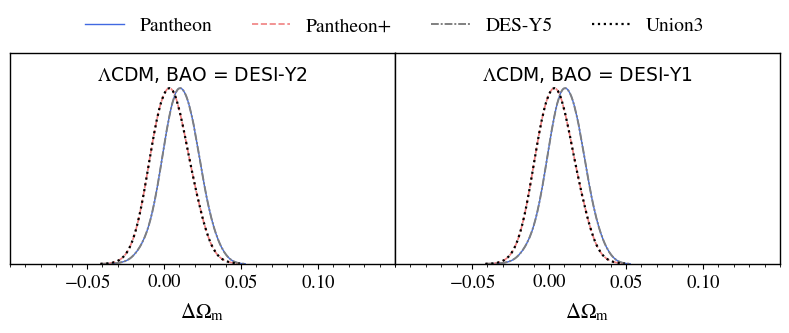

In [24]:
g = plots.get_single_plotter(width_inch=8.0, ratio=0.75)
g.settings.lw_contour = 1.2
g.settings.legend_rect_border = False
g.settings.figure_legend_frame = False
g.settings.axes_fontsize = 13.5
g.settings.legend_fontsize = 14.
g.settings.alpha_filled_add = 0.7
g.settings.lab_fontsize=15
g.legend_labels=False
g.settings.tight_layout=True

g.vmplots_1d(
    roots=[
        [
            diffchainv1[0],
            diffchainv1[1],
            diffchainv1[2],
            diffchainv1[3],
        ],
        [
            diffchainv2[0],
            diffchainv2[1],
            diffchainv2[2],
            diffchainv2[3],
        ],
     ],
    roots_per_param=True,
    nx=2,
    share_y=True,
    params=[u'delta_omegam',u'delta_omegam'],
    plot_3d_with_param=None,
    line_args=[
        {'lw': 1.0,'ls': 'solid', 'color':'royalblue'},
        {'lw': 1.2,'ls': 'dashed', 'color':'lightcoral'},
        {'lw': 1.4,'ls': '-.', 'color':'grey'},
        {'lw': 1.6,'ls': 'dotted', 'color':'black'},
        {'lw': 1.0,'ls': 'dashdot', 'color':'purple'}
    ],
    do_xlabel=True,
    vmmessage=[
      '$\Lambda$CDM, BAO = DESI-Y3',
      '$\Lambda$CDM, BAO = DESI-Y1'
    ],
    vmmessage_size=13.5,
    xlims=[[-0.1,0.15],[-0.1,0.15]],

)

g.settings.tight_layout=True
g.finish_plot(
    legend_labels=[
      'Pantheon', 
      'Pantheon+', 
      'DES-Y5', 
      'Union3' 
    ],
    legend_ncol=4,
)

ax = g.subplots
ax[0,0].minorticks_on()
ax[0,0].set_yticks([], minor=False)
ax[0,0].set_yticks([], minor=True)
# ----------------------------------------------------
ax[0,1].minorticks_on()
ax[0,1].set_yticks([], minor=False)
ax[0,1].set_yticks([], minor=True)
# ----------------------------------------------------
g.export(chaindir + 'EXAMPLE_PLOT_TENSION.pdf')